# Reto | Generación de un modelo inteligente de clasificación con redes neuronales profundas para la detección de amenazas aéreas

**Objetivos**:
El objetivo de este reto es poner en práctica los contenidos revisados durante el módulo realizando los siguientes pasos:

- Preparar una base de datos y generar los conjuntos de entrenamiento y prueba.
- Diseñar un modelo utilizando una red neuronal convolucional desde cero y determinar sus hiperparámetros.
- Diseñar un modelo utilizando una red neuronal convolucional utilizando un modelo pre-entrenado.
- Generar un modelo utilizando la herramienta Teachable Machine.
- Validar, evaluar y comparar los tres diferentes modelos generados y seleccionar el mejor considerando la exactitud como indicador de desempeño.
- Exportar los modelos generados para poder utilizarlos dentro de Colab o algún otro sitio.

## 1. Preprocesamiento de la base de datos

In [ ]:
# Montando Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
import pathlib
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
# Eliminando cualquiero archivo que no sea JPG, JPEG, PNG
!find /content/drive/MyDrive/Reto/datos/objetos -type f ! -name "*.jpg" ! -name "*.jpeg" ! -name "*.png" -delete


In [ ]:
# Directorio base
dir_base = '/content/drive/MyDrive/Reto/datos/objetos'
dir_base = pathlib.Path(dir_base)
conteo_img = len(list(dir_base.glob('*/*')))
print('El total de imágenes es de:',conteo_img)


El total de imágenes es de: 8218


In [ ]:
# Correr si hay error al momento de entrenar el primer modelo
# for img_path in dir_base.rglob('*.[jp][pn]g'):
#     try:
#         img = tf.io.read_file(str(img_path))
#         img = tf.image.decode_image(img,channels=3)
#     except:
#         print('Error al decodificar:',img_path)
#         os.remove(img_path)

## 2. Generación de conjuntos de entrenamiento, prueba y aumentación de datos

In [ ]:
# Tamaño de las imágenes y lote
alto_img = 224
ancho_img = 224
tam_lote = 32

Para la creación de los conjuntos de entrenamiento y prueba se usará la función:

```
image_dataset_from_directory
```



In [ ]:
# Definición del conjunto de entrenamiento
conj_entrenamiento = tf.keras.preprocessing.image_dataset_from_directory(
    dir_base,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(alto_img,ancho_img),
    batch_size=tam_lote
)

Found 8218 files belonging to 6 classes.
Using 6575 files for training.


In [ ]:
# Definición del conjunto de prueba
conj_prueba = tf.keras.preprocessing.image_dataset_from_directory(
    dir_base,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(alto_img,ancho_img),
    batch_size=tam_lote
)

Found 8218 files belonging to 6 classes.
Using 1643 files for validation.


In [ ]:
conj_entrenamiento = conj_entrenamiento.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
conj_prueba = conj_prueba.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


## 3. Diseña una arquitectura de una red neuronal convolucional profunda desde cero para resolver el problema de clasificación


In [ ]:
from tensorflow.keras import regularizers
# Definición del primer modelo
redConv = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(alto_img,ancho_img,3)),
    tf.keras.layers.Rescaling(1/255),

    # Data Augmentation
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.RandomContrast(0.15),

    # Convoluciones
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),


    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.35),

    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(256,activation='relu',
                          kernel_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128,activation='relu',
                          kernel_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(6,activation='softmax')
])
redConv.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_8 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_8               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_8 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_8               │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_24 (ReLU)                 │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 111, 111, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 111, 111, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_25 (ReLU)                 │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 55, 55, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 55, 55, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_26 (ReLU)                 │ (None, 55, 55, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 27, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 27, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 27, 27, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 27, 27, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_27 (ReLU)                 │ (None, 27, 27, 256)    │             

 Total params: 489,798 (1.87 MB)

 Trainable params: 488,838 (1.86 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Compilación del modelo
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

opt = Adam(learning_rate=5e-4)
redConv.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

# Reducir learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)
# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [ ]:
# Entrenamiento del modelo
evolucion = redConv.fit(
    conj_entrenamiento,
    validation_data = conj_prueba,
    epochs = 50,
    callbacks = [early_stopping,reduce_lr]
 )

Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 158ms/step - accuracy: 0.2283 - loss: 1.8989 - val_accuracy: 0.2155 - val_loss: 1.8310 - learning_rate: 5.0000e-04
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 33s 158ms/step - accuracy: 0.2852 - loss: 1.7381 - val_accuracy: 0.1838 - val_loss: 1.8083 - learning_rate: 5.0000e-04
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 33s 159ms/step - accuracy: 0.3149 - loss: 1.7068 - val_accuracy: 0.2374 - val_loss: 1.8031 - learning_rate: 5.0000e-04
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 33s 158ms/step - accuracy: 0.3427 - loss: 1.6546 - val_accuracy: 0.2635 - val_loss: 1.7927 - learning_rate: 5.0000e-04
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 33s 159ms/step - accuracy: 0.3464 - loss: 1.6328 - val_accuracy: 0.2696 - val_loss: 1.7147 - learning_rate: 5.0000e-04
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 33s 158ms/step - accuracy: 0.3633 - loss: 1.6025 - val_accuracy: 0.2806 - val_loss: 1.7151 - learning_rate: 5.0000e-04
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 15

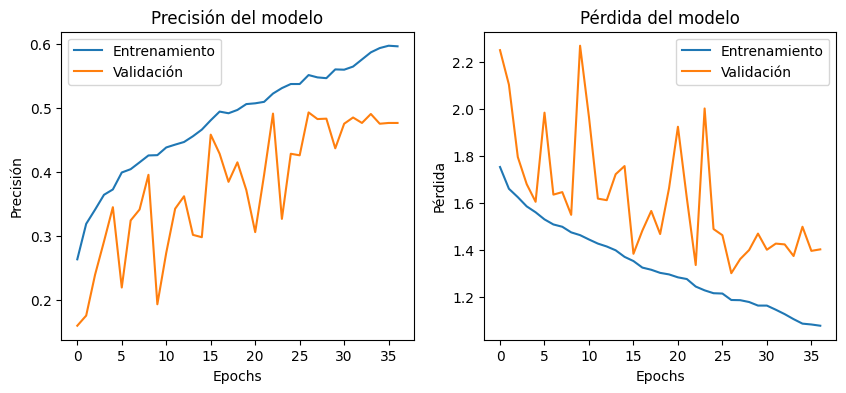

In [ ]:
# Gráfico de la evolución de entrenamiento y pérdida
# Historial de entrenamiento
hist = evolucion.history
plt.figure(figsize=(10,4))

# Presición del modelo
plt.subplot(1,2,1)
plt.plot(hist['accuracy'],label='Entrenamiento')
plt.plot(hist['val_accuracy'],label='Validación')
plt.xlabel('Epochs')
plt.ylabel('Precisión')
plt.title('Precisión del modelo')
plt.legend()

# Pérdida del modelo
plt.subplot(1,2,2)
plt.plot(hist['loss'],label='Entrenamiento')
plt.plot(hist['val_loss'],label='Validación')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.title('Pérdida del modelo')
plt.legend()

plt.show()

## 4. Diseña una arquitectura de una red neuronal convolucional profunda que utilice como base un modelo pre-entrenado para resolver el problema de clasificación

Al usar un modelo pre-entrenado se usará:

```
MobileNetV2
```
Así mismo, para evitar que los ecosistemas tengan problemas, se utilizarán pesos predefinidos.



In [ ]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomBrightness(0.3),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])
# Configurar modelo pre-entrenado
forma_img = (224,224,3)
modelo_base = tf.keras.applications.MobileNetV2(
    input_shape = forma_img,
    include_top = False,
    weights='imagenet'
)
modelo_base.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Es importante normalizar los datos de entrada en la base convolucional.

In [ ]:
from tensorflow.keras import regularizers
# Modelo completo
inputs = tf.keras.Input(shape=forma_img)
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = modelo_base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(
    128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
modelo_pre = tf.keras.Model(inputs, outputs)
modelo_pre.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Compilar modelo final
modelo_pre.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
# Entrenamiento
historial_pre = modelo_pre.fit(
    conj_entrenamiento,
    epochs=30,
    validation_data = conj_prueba,
    callbacks = [early_stopping,reduce_lr]
)

Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 46s 131ms/step - accuracy: 0.1832 - loss: 2.3499 - val_accuracy: 0.3147 - val_loss: 1.7080 - learning_rate: 1.0000e-05
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 24s 114ms/step - accuracy: 0.2392 - loss: 2.0089 - val_accuracy: 0.4078 - val_loss: 1.5582 - learning_rate: 1.0000e-05
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - accuracy: 0.2961 - loss: 1.8202 - val_accuracy: 0.4772 - val_loss: 1.4523 - learning_rate: 1.0000e-05
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 23s 110ms/step - accuracy: 0.3329 - loss: 1.7185 - val_accuracy: 0.5167 - val_loss: 1.3787 - learning_rate: 1.0000e-05
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 23s 112ms/step - accuracy: 0.3496 - loss: 1.6372 - val_accuracy: 0.5356 - val_loss: 1.3226 - learning_rate: 1.0000e-05
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 23s 112ms/step - accuracy: 0.3839 - loss: 1.5675 - val_accuracy: 0.5417 - val_loss: 1.2745 - learning_rate: 1.0000e-05
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 23s 11

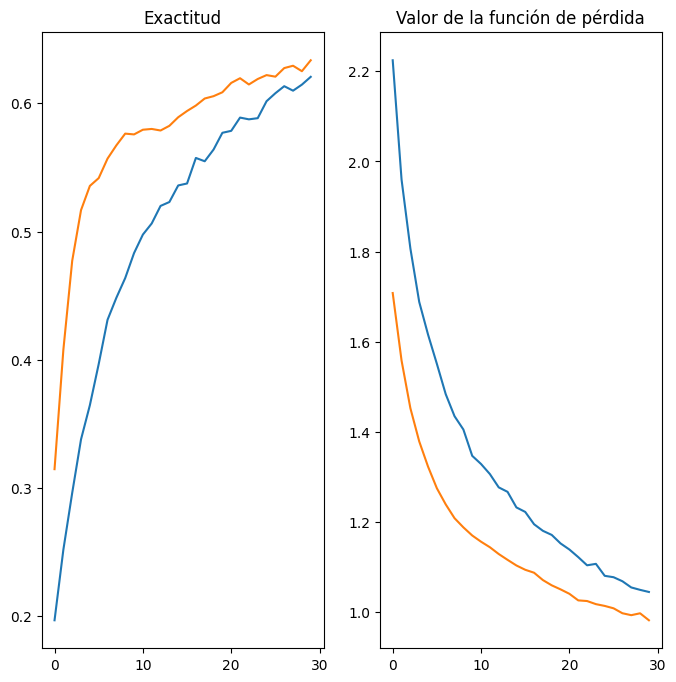

In [ ]:
# Desempeño del Modelo
exactitud_pre = historial_pre.history['accuracy']
exactitud_val_pre = historial_pre.history['val_accuracy']

perdida_pre = historial_pre.history['loss']
perdida_val_pre = historial_pre.history['val_loss']

rango_epoca = range(30)

# Gráfica de la evolución de entrenamiento y pérdida
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(rango_epoca,exactitud_pre,label='Exactitud Entrenamiento')
plt.plot(rango_epoca,exactitud_val_pre,label='Exactitud Validación')
plt.title('Exactitud')

plt.subplot(1,2,2)
plt.plot(rango_epoca,perdida_pre,label='Perdida Entrenamiento')
plt.plot(rango_epoca,perdida_val_pre,label='Perdida Validación')
plt.title('Valor de la función de pérdida')

plt.show()

### 4.1 Modelo Preentreado EfficientNetB0

In [ ]:
modelo_base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

modelo_base.trainable = False

In [ ]:
# Modelo Completo
inputs = tf.keras.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = modelo_base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(6,activation='softmax')(x)
modelo_completo = tf.keras.Model(inputs,outputs)
modelo_completo.summary()

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Compilación del modelo
opt = Adam(learning_rate=1e-4)
modelo_completo.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)
# Reducir Learning Rate
lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

In [ ]:
# Entrenamiento
historial = modelo_completo.fit(
    conj_entrenamiento,
    validation_data=conj_val,
    epochs=30,
    callbacks=[early_stopping,lr]
)

## 5. Modelo con Teachable Machine
Para la generación del modelo en Teachable Machine se declararán 6 clases:
1. Misil
2. Jet
3. Helicóptero
4. Dron
5. Cohete
6. Avión

Para la creación del modelo se eligirán las primeras 200 imágenes de cada clase.

Los hiperparámetros serán los siguientes:

- Épocas: 50
- Tamaño del lote: 32
- Tasa de aprendizaje : 0.001

In [ ]:
from keras import layers, Sequential
from PIL import Image, ImageOps
import numpy as np

# Definiendo ruta
ruta_modelo = '/content/drive/MyDrive/Reto/model.savedmodel1'

# Cargando modelo
modelo_tm = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224,224,3)),
    tf.keras.layers.TFSMLayer(ruta_modelo,call_endpoint='serving_default')
])

# Compilando el modelo
modelo_tm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


## 6. Entrena y ajusta las arquitecturas diseñadas

### 6.1 Primer Modelo

### 6.2 Modelo Preentrenado MobileNetV2

### 6.3 Modelo Preentrenado EfficientNetB0

### 6.4 Modelo de Teachable Machine

## 7. Comparativa de los tres modelos generados en el problema de clasificación

### 7.1 Evaluación del Primer Modelo

In [ ]:
# Pérdida y Exactitud
loss_redConv, acc_redConv = redConv.evaluate(conj_prueba)
print(f' Pérdida del modelo: {loss_redConv:.4f}')
print(f' Exactitud del modelo: {acc_redConv:.4f}')

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5013 - loss: 1.3530
 Pérdida del modelo: 1.3245
 Exactitud del modelo: 0.5155


### 7. 2 Evaluación del Modelo Preentrenado MobileNetV2

In [ ]:
loss_pre, acc_pre = modelo_pre.evaluate(conj_prueba)
print(f' Pérdida del modelo pre-entrenado: {loss_pre:.4f}')
print(f' Exactitud del modelo pre-entrenado: {acc_pre:.4f}')

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6100 - loss: 1.0285
 Pérdida del modelo pre-entrenado: 0.9816
 Exactitud del modelo pre-entrenado: 0.6336


### 7. 3 Evaluación del Modelo Preentrenado EfficientNetB0

In [ ]:
loss_eff, acc_eff = modelo_completo.evaluate(conj_prueba)
print(f' Pérdida del modelo pre-entrenado: {loss_eff:.4f}')
print(f' Exactitud del modelo pre-entrenado: {acc_eff:.4f}')

### 7.4 Evaluación del modelo de Teachable Machine

In [ ]:
# Pérdida y Exactitud
loss_tm, acc_tm = modelo_tm.evaluate(conj_prueba)
print(f' Pérdida del modelo: {loss_tm:.4f}')
print(f' Exactitud del modelo: {acc_tm:.4f}')

52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 208ms/step - accuracy: 0.1757 - loss: 7.4335
 Pérdida del modelo: 7.3526
 Exactitud del modelo: 0.1808


### 7.4 Comparación de los tres modelos

#### 7.4.1 Comparación de exactitudes

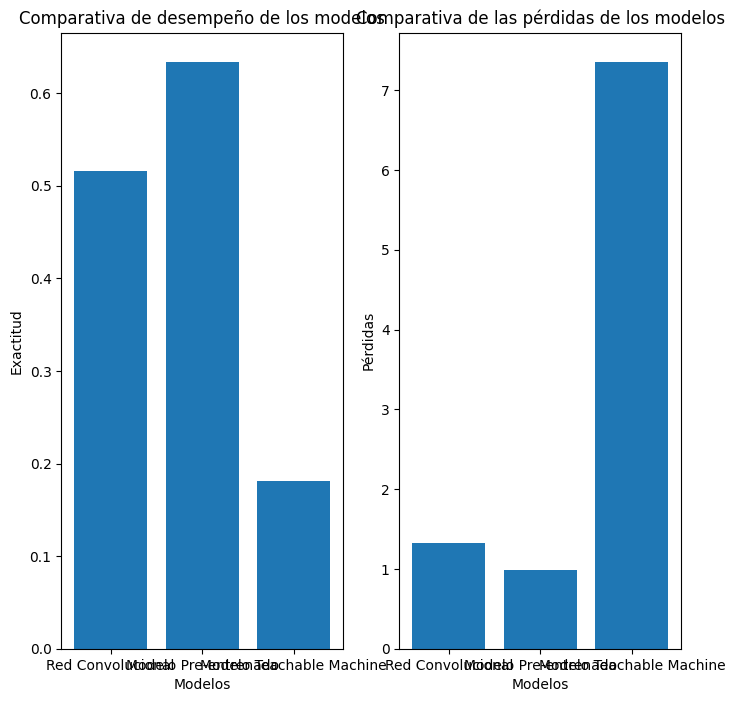

In [ ]:
exactitudes = [acc_redConv,acc_pre,acc_tm]
modelos = ['Red Convolucional','Modelo Pre-entrenado','Modelo Teachable Machine']
plt.figure(figsize=(15,15))
plt.bar(modelos,exactitudes)
plt.xlabel('Modelos')
plt.ylabel('Exactitud')
plt.title('Comparativa de desempeño de los modelos')

#### 7.4.2 Comparación de pérdidas

In [ ]:
perdidas = [loss_redConv,loss_pre,loss_tm]
modelos = ['Red Convolucional','Modelo Pre-entrenado','Modelo Teachable Machine']
plt.figure(figsize=(15,15))
plt.bar(modelos,perdidas)
plt.xlabel('Modelos')
plt.ylabel('Pérdidas')
plt.title('Comparativa de las pérdidas de los modelos')
plt.show()

## 8. Selección del mejor modelo

## 9. Modelos exportados

### 9.1 Primer Modelo

In [ ]:
# Guardar modelo
redConv.save('/content/drive/MyDrive/Reto/modelo_redConv.keras')

# Cargar modelo
modelo_redConv = tf.keras.models.load_model(
    '/content/drive/MyDrive/Reto/modelo_redConv.keras')

### 9.2 Modelo pre-entrenado

In [ ]:
# Guardar modelo
modelo_pre.save('/content/drive/MyDrive/Reto/modelo_pre.keras')

# Cargar modelo
modelo_prentrenado = tf.keras.models.load_model(
    '/content/drive/MyDrive/Reto/modelo_pre.keras')

### 9.3 Modelo de Teachable Machine

In [ ]:
# Cargar modelo
modelo_tm.save('/content/drive/MyDrive/Reto/modelo_TM.keras')

# Cargar modelo
modelo_TM = tf.keras.models.load_model(
    '/content/drive/MyDrive/Reto/modelo_TM.keras')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 320 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
